In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/.kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [2]:
%cd /content/drive/My Drive/.kaggle

/content/drive/My Drive/.kaggle


In [3]:
pwd

'/content/drive/My Drive/.kaggle'

In [4]:
!ls '/content/drive/My Drive/.kaggle'

kaggle.json


In [5]:
!kaggle competitions download -c tgs-salt-identification-challenge

 82% 34.0M/41.4M [00:00<00:00, 22.3MB/s]
100% 41.4M/41.4M [00:00<00:00, 44.9MB/s]
 94% 153M/163M [00:03<00:00, 47.5MB/s]
100% 163M/163M [00:03<00:00, 48.5MB/s]
100% 217M/217M [00:05<00:00, 49.3MB/s]

 92% 35.0M/37.9M [00:01<00:00, 19.8MB/s]
100% 37.9M/37.9M [00:01<00:00, 37.3MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 37.5MB/s]
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 44.8MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 29.9MB/s]


In [7]:
os.listdir()

['kaggle.json',
 'flamingo.zip',
 'test.zip',
 'competition_data.zip',
 'train.zip',
 'sample_submission.csv',
 'depths.csv',
 'train.csv']

In [0]:
!unzip '/content/drive/My Drive/.kaggle/train.zip'

In [0]:
assert len(os.listdir(os.path.join('images'))) == len(os.listdir(os.path.join('masks')))

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

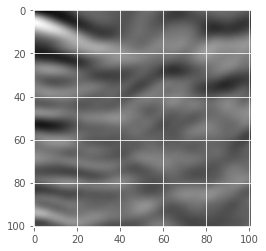

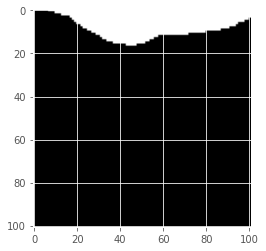

In [13]:
# visualize the data
img = cv2.imread('images/'+os.listdir(os.path.join('images'))[0])
plt.imshow(img, cmap='seismic', interpolation='bilinear')
plt.show()

msk = cv2.imread('masks/'+os.listdir(os.path.join('masks'))[0])
plt.imshow(msk, cmap='seismic')
plt.show()

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [0]:
height=128
width=128
channels=1
number_of_images=len(os.listdir(os.path.join('images')))

In [41]:
X=np.zeros((number_of_images,width,height,channels),dtype='float32')
Y=np.zeros((number_of_images,width,height,channels),dtype='float32')
for i in range(number_of_images):
  img_path=os.listdir(os.path.join('images'))[i]
  mask_path=os.listdir(os.path.join('masks'))[i]
  x=load_img('images/'+img_path,color_mode = "grayscale")
  y=load_img('masks/'+mask_path,color_mode = "grayscale")
  x_img = img_to_array(x)
  x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
  msk = img_to_array(y)
  msk = resize(msk, (128, 128, 1), mode = 'constant', preserve_range = True)

  X[i] = x_img/255.0
  Y[i] = msk/255.0
  if(i%1000==0):
    print(i)

0
1000
2000
3000


In [43]:
X.shape

(4000, 128, 128, 1)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [45]:
input_img = Input((height, width, channels), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

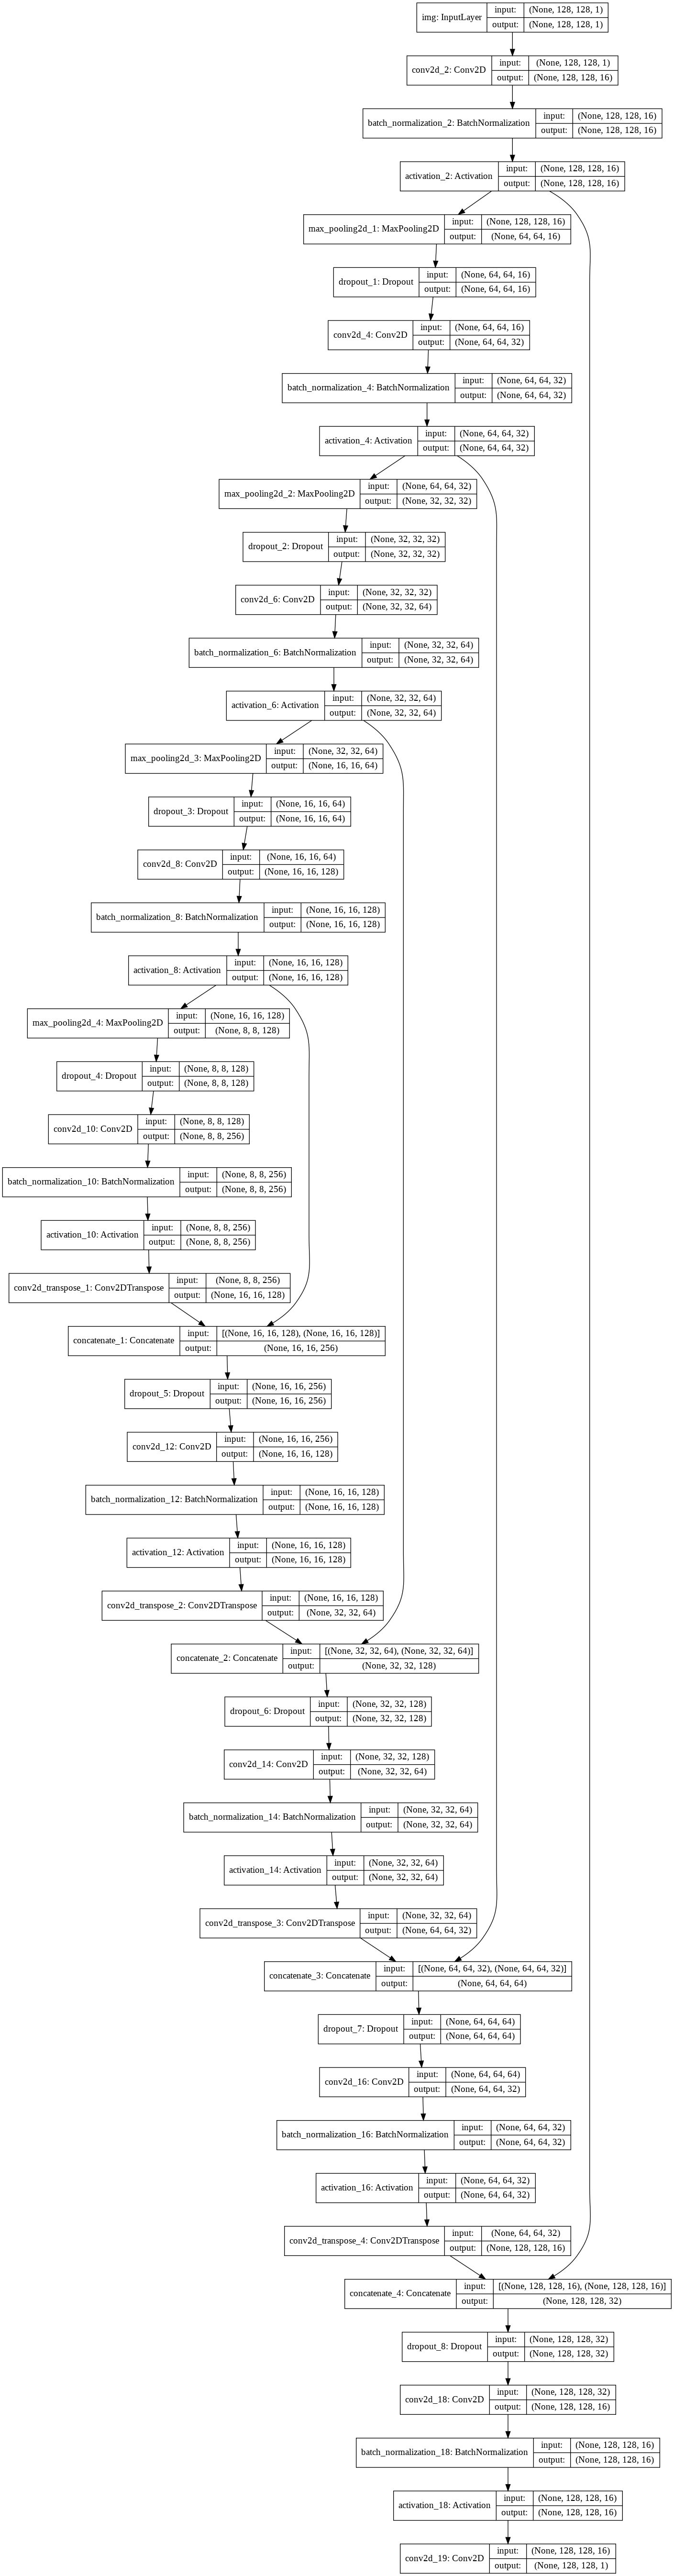

In [46]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [47]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_data=(X_test, Y_test),callbacks=callbacks)

Train on 2800 samples, validate on 1200 samples
Epoch 1/20
2800/2800 [==============================] - 354s 126ms/step - loss: 0.5275 - accuracy: 0.7489 - val_loss: 0.9206 - val_accuracy: 0.6662

Epoch 00001: val_loss improved from inf to 0.92057, saving model to model-tgs-salt.h5
Epoch 2/20
2800/2800 [==============================] - 355s 127ms/step - loss: 0.3766 - accuracy: 0.8490 - val_loss: 1.9134 - val_accuracy: 0.5733

Epoch 00002: val_loss did not improve from 0.92057
Epoch 3/20
2800/2800 [==============================] - 351s 125ms/step - loss: 0.3234 - accuracy: 0.8686 - val_loss: 1.6615 - val_accuracy: 0.5985

Epoch 00003: val_loss did not improve from 0.92057
Epoch 4/20
2800/2800 [==============================] - 350s 125ms/step - loss: 0.3030 - accuracy: 0.8730 - val_loss: 3.7509 - val_accuracy: 0.3307

Epoch 00004: val_loss did not improve from 0.92057
Epoch 5/20
2800/2800 [==============================] - 354s 126ms/step - loss: 0.2904 - accuracy: 0.8813 - val_loss:

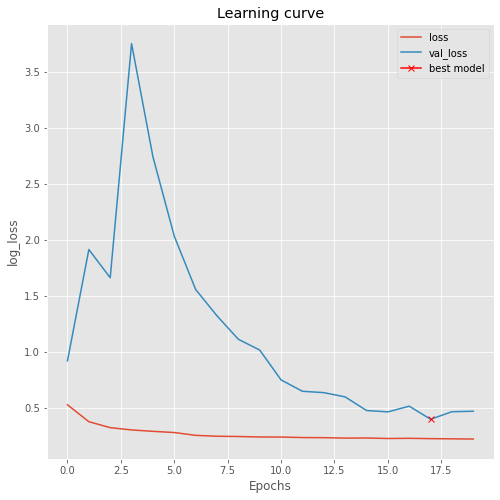

In [49]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

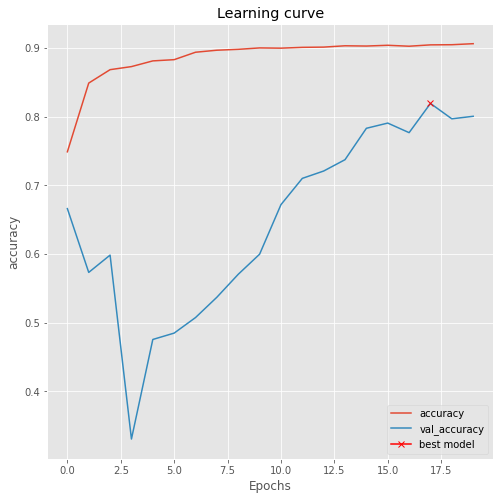

In [53]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();

In [0]:
model.load_weights('model-tgs-salt.h5')

In [55]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, Y_test, verbose=1)

1200/1200 [==============================] - 34s 29ms/step


[0.398363436460495, 0.819379985332489]

In [57]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

1200/1200 [==============================] - 34s 28ms/step


:INPUT:


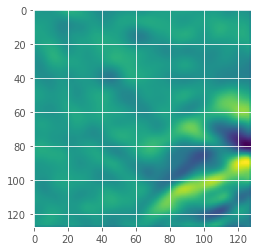

:ACTUAL:


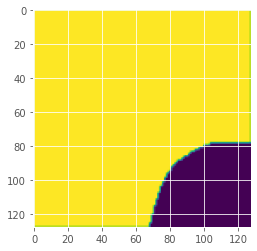

:PREDICTED:


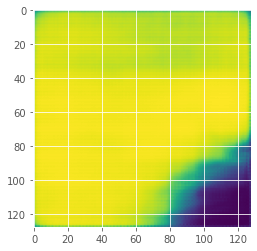

In [62]:
idex = 651

pred = model.predict(X_test[idex].reshape(1,height,width,channels))
print(":INPUT:")
plt.imshow(X_test[idex].reshape(height, width))
plt.show()

print(":ACTUAL:")
plt.imshow(Y_test[idex].reshape(height, width))
plt.show()

print(":PREDICTED:")
plt.imshow(pred[0].reshape(height, width))
plt.show()

:INPUT:


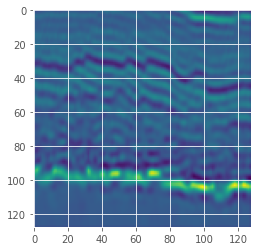

:ACTUAL:


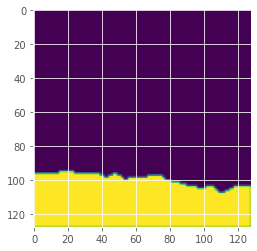

:PREDICTED:


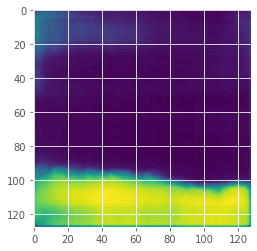

In [98]:
idex = 433

pred = model.predict(X_test[idex].reshape(1,height,width,channels))
print(":INPUT:")
plt.imshow(X_test[idex].reshape(height, width))
plt.show()

print(":ACTUAL:")
plt.imshow(Y_test[idex].reshape(height, width))
plt.show()

print(":PREDICTED:")
plt.imshow(pred[0].reshape(height, width))
plt.show()

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

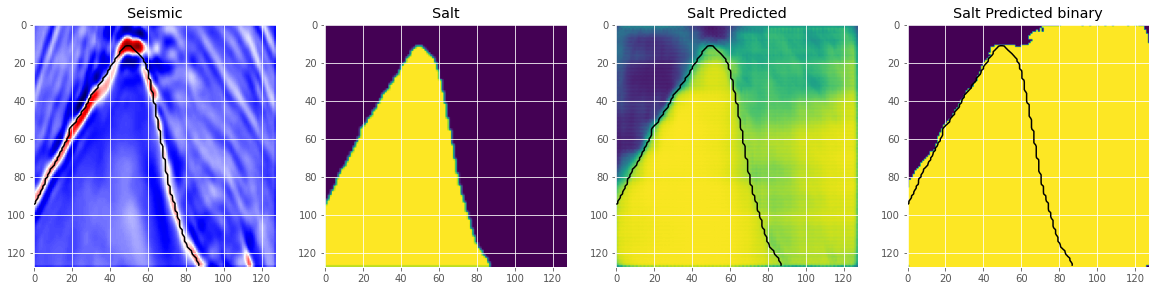

In [65]:
plot_sample(X_train, Y_train, preds_train, preds_train_t)

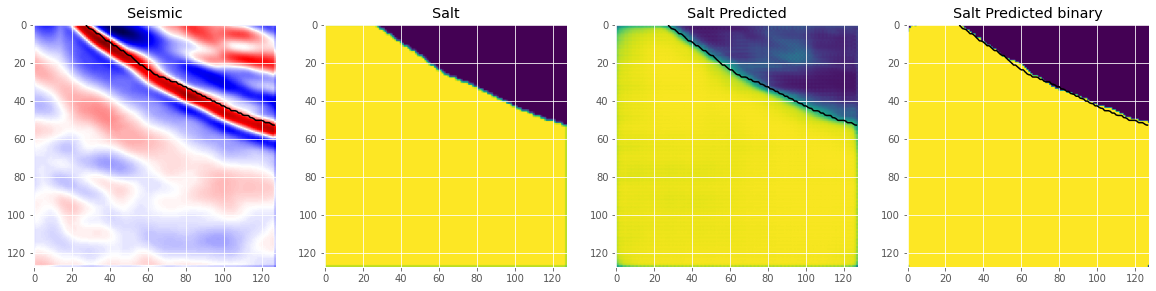

In [66]:
plot_sample(X_train, Y_train, preds_train, preds_train_t)

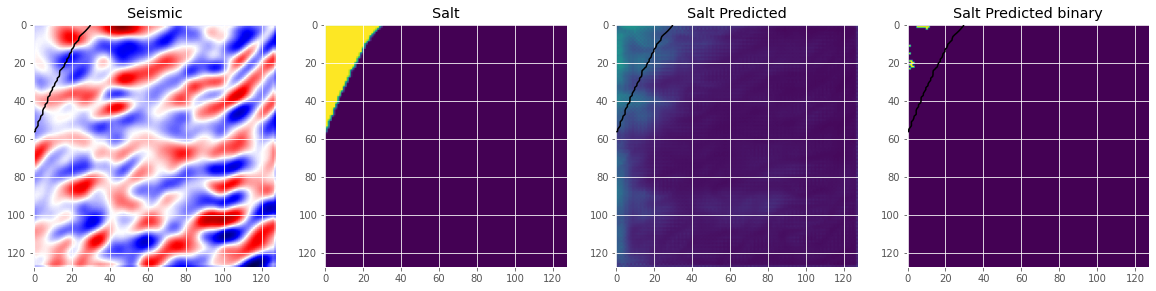

In [75]:
plot_sample(X_test, Y_test, preds_val, preds_val_t)

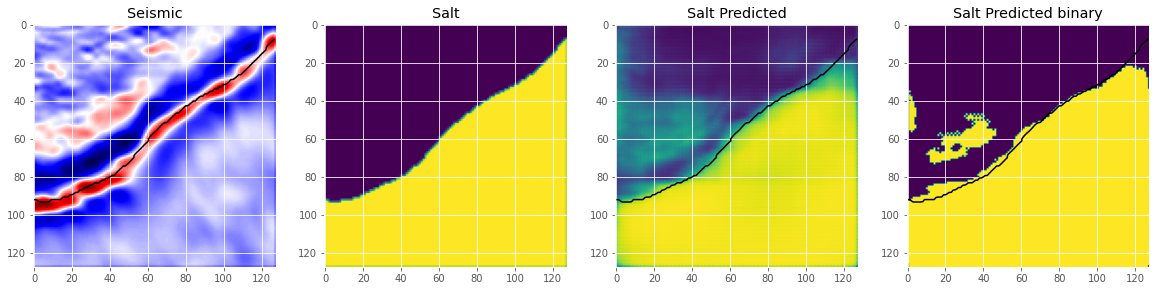

In [74]:
plot_sample(X_train, Y_train, preds_train, preds_train_t)

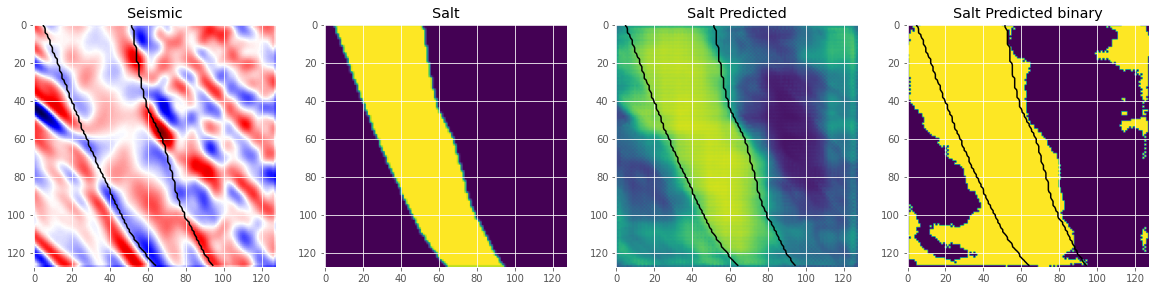

In [76]:
plot_sample(X_test, Y_test, preds_val, preds_val_t)

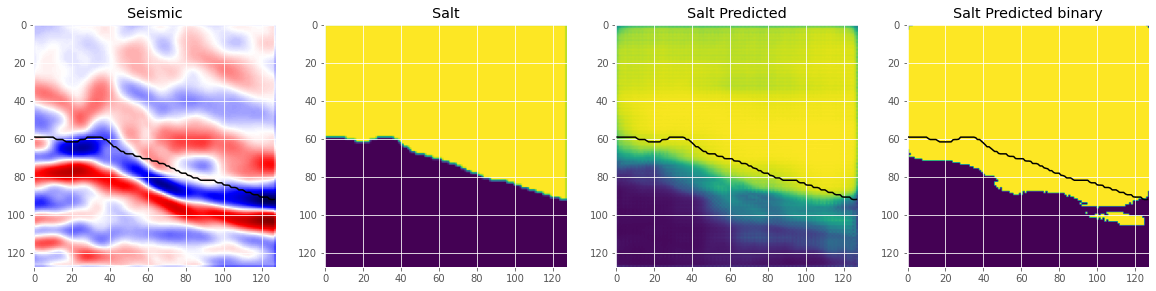

In [85]:
plot_sample(X_test, Y_test, preds_val, preds_val_t)